<a href="https://colab.research.google.com/github/jiananwu72/LuFeO3Detect/blob/main/LuFeO3/LFOWindowingAutomated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Environment Installation & Data Loading

In [1]:
# Downloading packages
!pip install -q pyNSID sidpy atomap nanonispy gwyfile pyTEMlib wget ipympl importlib
!pip install numpy==1.26.4

In [2]:
# Connecting to widget (only supported by numpy 1) to produce interacting plots
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt
import sys

# Connecting to Google Drive
if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive
    drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

Mounted at /content/drive


##Automated Detection of Layers from Pictures

This cell loads one image at a time.

Non-Stacked


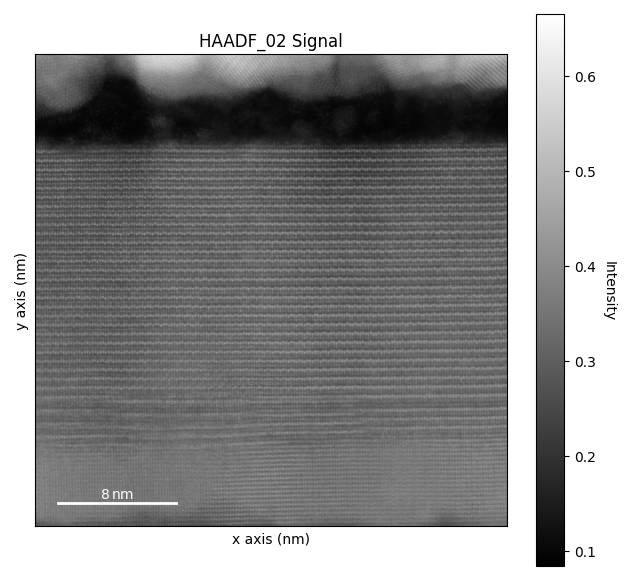

In [109]:
import skimage
import hyperspy.api as hs

# Change the name of s_load to load different plots.
# Note that some datasets are in stacks and their data will be 3-dimension,
# where the first dimention is the index of a single stacked image. We want to
# look at one image each of the time, so for those stacked images, please change
# stack_num to view different images.

# Load one file at a time
s_load = hs.load('/content/drive/MyDrive/Data/LFO/HAADF_02.dm3')
# s_load = hs.load('/content/drive/MyDrive/Data/LFO/FEI HAADF Stack 06.dm3')

stack_num = 0 # The index of stacked image
if len(s_load.data.shape) == 2: # Non-stacked
    print("Non-Stacked")
    s = s_load
else: # Stacked, where s_load.data.shape = 3
    print("Stacked")
    s = s_load.inav[stack_num]

# Plot the image
image = s
plt.close()
s.plot()

Here we crop horizontal strips that contains only one layer of Lu atoms. I want to automate the process of finding Lu atoms, but there are some hyperparameters here that needs to be tuned for each of the images (labeled TUNE THIS) so please check them out.

We will tune parameters here about window width and left & right boundaries for window detections.

Text(0.5, 1.0, 'Window strenghts by pixels')

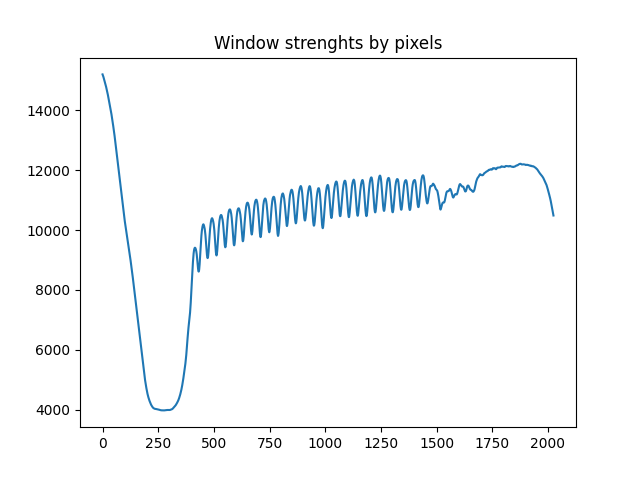

In [116]:
# Adjust window_height_nm so one window can perfectly cover.
# This value can vary because layers are not horizontal in some images, so we
# possibly need to make it a little bit larger to include Lu atoms in our
# horizontal window strips.
window_height_nm = 0.35 # TUNE THIS
scale = s.axes_manager['x'].scale
window_height = int(window_height_nm/scale)

# Adjust left and right boundaries to exclude any noisy signals, e.g. if you
# look at image HAADF_01, the first 400 pixels for the first few layers are
# really noisy and we want to skip them.
left_bound = 250 # TUNE THIS
right_bound = 250 # TUNE THIS
strengths = []
H, W = s.data.shape
for i in range(H-window_height):
    s_cropped = s.isig[left_bound:W-right_bound, i:i+window_height]
    strengths.append(np.array(s_cropped).sum())

# Plotting
strengths = np.array(strengths)
plt.close()
plt.figure()
plt.plot(strengths)
plt.title("Window strenghts by pixels")

To see whether the window heights, left and right boundaries we have chosen make sense, we test one of the windows and see the results in the cell below and adjust accordingly.

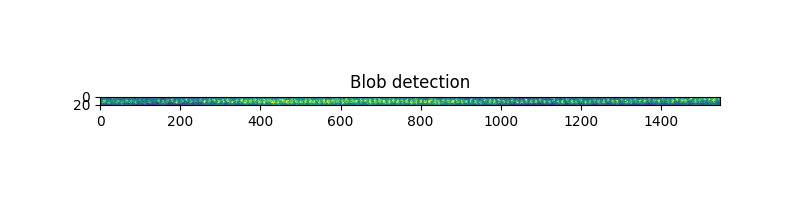

In [117]:
y_pixel = 451
s_cropped = s.isig[left_bound:W-right_bound, y_pixel:y_pixel+window_height]

fig1, ax = plt.subplots(1, 1,figsize=(8,2), sharex=True, sharey=True)
plt.title("Blob detection")
plt.imshow(s_cropped, interpolation='nearest', vmax=np.median(np.array(s_cropped))+3*np.std(np.array(s_cropped)))

In the ideal case, the windows locating at local strengths maximums are where Lu layers are. This cell identifies those

Things could go wrong if the windows are a little too wide and includes some atoms from the surrounding Fe layers. In that situation, a more complicated method is needed to find out the peaks and it is easier to just tune stuffs better.

##Atom Positions Finding & Refining Functions

Still thinking of a better way to iteratively run without errors

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter
from skimage.filters import median, threshold_yen
from skimage.morphology import disk

def Thresholding(image, get_plot = False):
    strip = image.data
    col_median = np.median(strip, axis=0)

    scale = image.axes_manager['x'].scale
    disk_param = int(0.235/scale)
    bg1 = median(strip, disk(20))
    flat = strip - bg1

    th = threshold_yen(flat)
    mask = flat > th

    if get_plot:
        fig, axes = plt.subplots(2,1, figsize=(8,5))
        axes[0].imshow(image, cmap='gray', origin='lower')
        axes[0].set_title("Original")
        axes[1].imshow(mask, cmap='gray', origin='lower')
        axes[1].set_title("Thresholded")
        plt.tight_layout()
        plt.show()

    return mask

In [119]:
from skimage.morphology import remove_small_objects, remove_small_holes, binary_closing, binary_opening, disk

def Cleaning(image, mask, get_plot = False, obj_param_nm = 0.12, holes_param_nm = 0.12):
    scale = image.axes_manager['x'].scale
    obj_param = int(obj_param_nm/scale)
    holes_param = int(holes_param_nm/scale)
    clean1 = binary_closing(mask)
    clean2 = remove_small_objects(clean1, min_size=obj_param)
    clean3 = remove_small_holes(clean2, area_threshold=holes_param)
    clean4 = binary_opening(clean3)
    clean = clean4

    if get_plot:
        fig, axes = plt.subplots(5,1, figsize=(8,5))
        axes[0].imshow(mask,   cmap='gray', origin='lower')
        axes[0].set_title("Before")
        axes[1].imshow(clean1, cmap='gray', origin='lower')
        axes[1].set_title("After 1")
        axes[2].imshow(clean2, cmap='gray', origin='lower')
        axes[2].set_title("After 2")
        axes[3].imshow(clean3, cmap='gray', origin='lower')
        axes[3].set_title("After 3")
        axes[4].imshow(clean4, cmap='gray', origin='lower')
        axes[4].set_title("After 4")
        for ax in axes:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    return clean

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max


def GetPositions(image, mask, clean, get_plot = False, min_dist_nm = 0.1):
    dist = distance_transform_edt(clean)

    scale = image.axes_manager['x'].scale
    min_dist = int(min_dist_nm/scale)

    atom_positions = peak_local_max(
        dist,
        min_distance=min_dist,
        threshold_abs=0,
        labels=clean
    )

    y_centers, x_centers = atom_positions[:,0], atom_positions[:,1]
    masked_img = image.data.copy()
    masked_img[~mask] = 0

    if get_plot:
        fig1, ax = plt.subplots(2, 1,figsize=(8,4))
        ax[0].imshow(masked_img, cmap='gray', origin='lower')
        ax[0].set_title("Masked image")
        ax[1].imshow(masked_img, interpolation='nearest', vmax=np.median(np.array(image))+3*np.std(np.array(image)))
        ax[1].scatter(x_centers, y_centers, c='r', s=20, alpha = .5)
        ax[1].set_title("Masked → local max")
        for a in ax: a.axis('off')
        plt.tight_layout()
        plt.show()

    return masked_img, atom_positions


In [126]:
import pyTEMlib.atom_tools

def AtomRefine(image, masked_img, atom_positions, get_plot = False, atom_radius_nm = 0.174):

    scale = image.axes_manager['x'].scale
    atom_radius = int(atom_radius_nm/scale)
    sym = pyTEMlib.atom_tools.atom_refine(masked_img, atom_positions, atom_radius, max_int = 0, min_int = 0, max_dist = 2)
    refined_atoms = np.array(sym['atoms'])

    if get_plot:
        fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True, sharey=True)
        ax[0].imshow(image.T)
        ax[0].scatter(refined_atoms[:,1],refined_atoms[:,0],  s=10, alpha = 0.3, color = 'red')
        ax[0].set_title('refined atom postion')
        ax[1].imshow(image.T)
        ax[1].scatter(atom_positions[:, 1], atom_positions[:, 0], c='r', s=10, alpha = .3);
        ax[1].set_title('blobs on image');

    return refined_atoms

using radius  11 pixels


  0%|          | 0/133 [00:00<?, ?it/s]

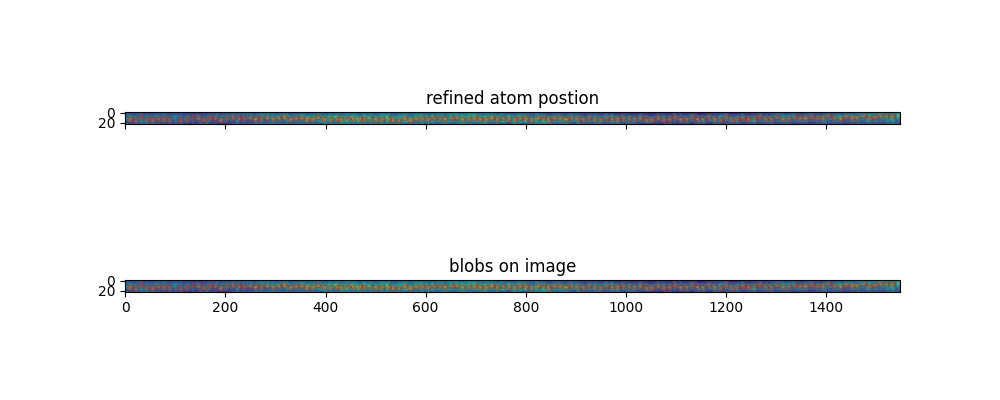

In [127]:
image = s_cropped
mask = Thresholding(image)
clean = Cleaning(image, mask)
masked_img, atom_positions = GetPositions(image, mask, clean)
refined_atoms = AtomRefine(image, masked_img, atom_positions, get_plot = True)

##Atom Strength Labeling & Analysis

In [128]:
atoms = refined_atoms[refined_atoms[:, 1].argsort()]
# atoms = atoms[:-1] #temporary fix

imagearr = np.array(image)
H, W = imagearr.shape

radius = 2

# Prepare a list to collect all 3×3 patches and keep track of valid indices
patches = []
valid_indices = []
masked_atoms = atoms

for idx in range(atoms.shape[0]):
    y, x = atoms[idx]
    cx = int(round(x))
    cy = int(round(y))

    if (cx - radius < 0) or (cy - radius < 0) or (cx + radius >= W) or (cy + radius >= H):
        mask = ~((masked_atoms[:,0] == y) & (masked_atoms[:,1] == x))
        masked_atoms = masked_atoms[mask]
        continue

    patch = imagearr[cy - radius : cy + radius + 1,
                     cx - radius : cx + radius + 1]

    patches.append(patch)
    valid_indices.append(idx)

# Convert the list of patches into a single NumPy array of shape (N_valid, 3, 3)
if len(patches) > 0:
    patches_array = np.stack(patches)
else:
    patches_array = np.empty((0, radius*2 + 1, radius*2 + 1))

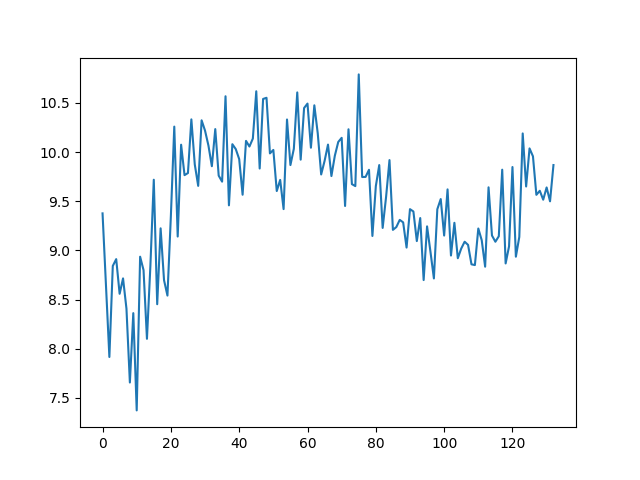

In [129]:
sums = []
for i in range(len(patches_array)):
    sums.append(np.sum(np.array(patches_array[i])))

plt.figure()
# plt.hist(sums, bins=20);
plt.plot(sums);

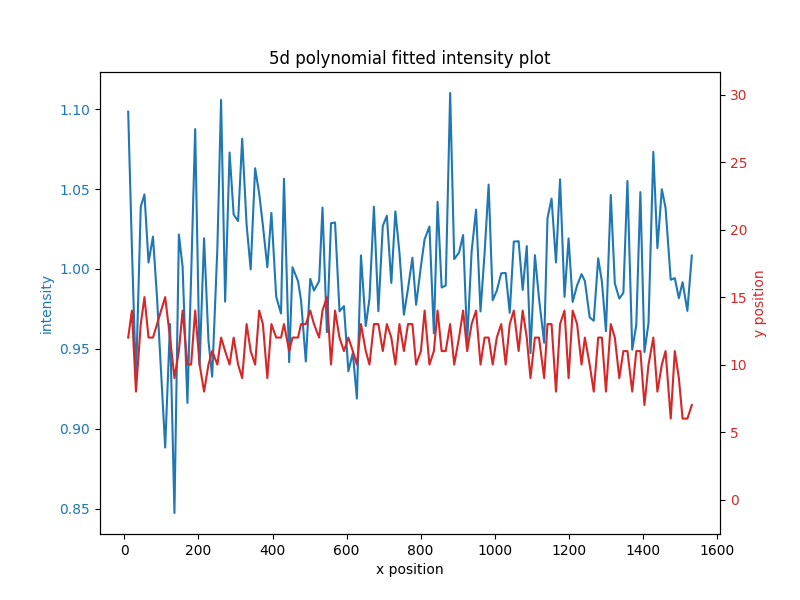

In [130]:
x_loc = masked_atoms[:, 1]
y_loc = masked_atoms[:, 0]
coeffs = np.polyfit(x_loc, sums, deg=5)
I_bg_poly = np.polyval(coeffs, x_loc)

fig, ax1 = plt.subplots(figsize=(8,6))
ax1.plot(x_loc, sums/I_bg_poly, color='tab:blue', label='intensity')
ax1.set_xlabel('x position')
ax1.set_ylabel('intensity', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(x_loc, y_loc, color='tab:red', label='y position')
ax2.set_ylabel('y position', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ymin, ymax = y_loc.min(), y_loc.max()
ymin = ymin - (ymax-ymin)*0.95
ymax = ymax + (ymax-ymin)*0.95
ax2.set_ylim(ymin, ymax)

plt.title("5d polynomial fitted intensity plot")
plt.show()

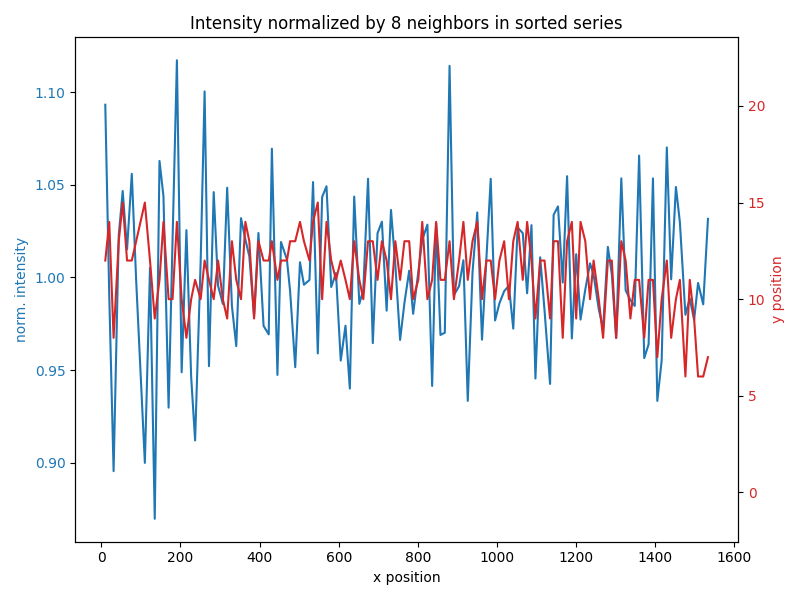

In [131]:
half = 4
N = len(sums)
norm_sums = np.empty(N)

for i in range(N):
    start = max(0, i - half)
    end   = min(N, i + half + 1)
    window = sums[start:end]

    rel_idx = i - start
    neigh_vals = np.delete(window, rel_idx)

    local_mean = neigh_vals.mean() if neigh_vals.size>0 else np.nan
    norm_sums[i] = sums[i] / local_mean

# now plot norm_sums vs x_loc alongside y_loc
fig, ax1 = plt.subplots(figsize=(8,6))

ax1.plot(x_loc, norm_sums,
         color='tab:blue', label='intensity (9-pt local norm)')
ax1.set_xlabel('x position')
ax1.set_ylabel('norm. intensity', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(x_loc, y_loc,
         color='tab:red', label='y position')
ax2.set_ylabel('y position', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# pad the y2 axis
ymin, ymax = y_loc.min(), y_loc.max()
ax2.set_ylim(ymin - 0.95*(ymax-ymin),
             ymax + 0.95*(ymax-ymin))

plt.title("Intensity normalized by 8 neighbors in sorted series")
fig.tight_layout()
plt.show()
